# Imports

In [1]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [292]:
def groupby_min(df, dur):
    temp = df.copy()
    temp.index = map(lambda x: pd.datetime.combine(datetime.datetime.today()
                                                   , x), temp.index.time)
    return temp.resample(dur).mean()

def plot_camera_avg(df, cam=None, dur="1Min"):
    if cam == None:
        weekday = groupby_min(df[(df.index.weekday < 5)], dur)
        weekend = groupby_min(df[(df.index.weekday >= 5)], dur)

    else:
        weekday = groupby_min(df[(df.index.weekday < 5) & 
                                 (df.cam_id == cam)], dur)
        weekend = groupby_min(df[(df.index.weekday >= 5) & 
                                 (df.cam_id == cam)], dur)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    
    weekday["count"].plot(ax=ax1, c="k", alpha=0.5, label="Weekday")
    weekend["count"].plot(ax=ax1, c="b", alpha=0.5, label="Weekend")

    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.grid(True, which="both")
    ax1.tick_params(axis="both", which="both", labelsize=12)
    ax1.legend(ncol=3, fontsize=12)
    
    return fig, ax1

# Load Data

In [2]:
counts = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str,
                        "count": int, "imtime": str}, parse_dates=["date"],
                 infer_datetime_format=True, index_col="date")
counts.head(2)

,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [3]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


In [182]:
df = counts[["cam_id", "count"]].reset_index() \
        .merge(cams[cams["people"] == 1.][["cam_id", "boro", "description"]]) \
        .set_index("date")
df.head(2)

,cam_id,count,boro,description
date,,,,
2017-06-27 20:09:22,368,1,Manhattan,1 Ave @ 110 St
2017-06-27 20:10:39,368,1,Manhattan,1 Ave @ 110 St


In [93]:
mta = pd.read_csv("../data/external/turnstile_170729.txt", parse_dates=["DATE"]) \
        .rename(columns=lambda x: x.strip())
mta.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-07-22,00:00:00,REGULAR,6262933,2121633
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-07-22,04:00:00,REGULAR,6262960,2121637


# Turstile Analysis

In [268]:
cams[cams["description"] == "Stillwell Ave @ Surf Ave"]

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
130,856,750,Stillwell Ave @ Surf Ave,40.575565,-73.981202,1.0,1.0,Brooklyn,11224


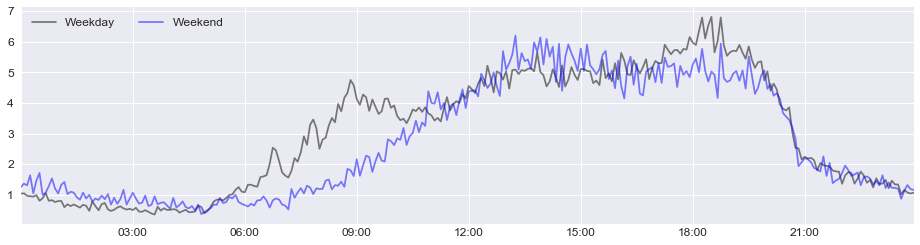

In [294]:
fig, ax = plot_camera_avg(df, 503, dur="5Min")

In [290]:
turnstiles = mta[(mta["STATION"] == 'CONEY IS-STILLW') & (mta["DATE"].dt.weekday < 5)].groupby(["SCP", "DATE", "TIME"]).sum()

for idx, row in turnstiles.iterrows():
    scp = 0
    row_0 = row.copy()
    if ((idx[0] == scp) & (idx[2] == "01:00:00")):
        turnstiles.loc[idx]["ENTRIES"] = 0
        turnstiles.loc[idx]["EXITS"] = 0
        scp = idx[0]
        print scp
    else:
        turnstiles.loc[idx]["ENTRIES"] = row_0.ENTRIES - entries_0
        turnstiles.loc[idx]["EXITS"] = row_0.EXITS - exits_0
    entries_0 = row_0.ENTRIES
    exits_0 = row_0.EXITS
    
    if abs(turnstiles.loc[idx]["ENTRIES"]) > 10000:
        turnstiles.loc[idx]["ENTRIES"] = 0
        turnstiles.loc[idx]["EXITS"] = 0

def avg_exits(row):
    if row.index[0] == "01:00:00":
        return 1. * row.EXITS / 6
    else:
        return 1. * row.EXITS / 7
    
def avg_entries(row):
    if row.index[0] == "01:00:00":
        return 1. * row.ENTRIES / 6
    else:
        return 1. * row.ENTRIES / 7
        
data = turnstiles.reset_index().drop(["DATE"], axis=1).groupby(["SCP", "TIME"]).sum().reset_index().groupby(["TIME"]).sum()
data["AVG_EXITS"] = data.apply(avg_exits, axis=1)
data["AVG_ENTRIES"] = data.apply(avg_entries, axis=1)
data["DIFF"] = abs(data.AVG_EXITS - data.AVG_ENTRIES)
data["SUM"] = data.AVG_ENTRIES + data.AVG_EXITS
data[data.AVG_EXITS > 100]

,ENTRIES,EXITS,AVG_EXITS,AVG_ENTRIES,DIFF,SUM
TIME,,,,,,
01:00:00,810,5617,802.428571,115.714286,686.714286,918.142857
05:00:00,1492,1587,226.714286,213.142857,13.571429,439.857143
09:00:00,14127,6464,923.428571,2018.142857,1094.714286,2941.571429
13:00:00,11317,13665,1952.142857,1616.714286,335.428571,3568.857143
17:00:00,21167,18072,2581.714286,3023.857143,442.142857,5605.571429
21:00:00,19757,18975,2710.714286,2822.428571,111.714286,5533.142857


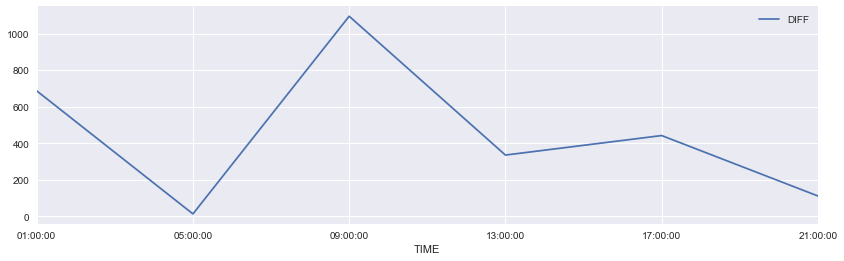

In [287]:
data[data.AVG_EXITS > 100][["DIFF"]].plot(figsize=(14,4))

In [ ]:
data[data.AVG_EXITS > 100][["SUM"]].plot(figsize=(14,4), marker="o", ax=ax)